# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
            * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 설치 및 로딩
        * requirements.txt 파일로 부터 라이브러리 설치
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다. 
        * 필요하다고 판단되는 라이브러리를 추가하세요.

변수 선정할 때, 고려

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [89]:
path = ''

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [90]:
# from google.colab import drive
# drive.mount('/content/drive')

### (2) 라이브러리 설치 및 불러오기

#### 1) 설치

* requirements.txt 파일을 아래 위치에 두고 다음 코드를 실행하시오.
    * 로컬 : 다음 코드셀 실행
    * 구글콜랩 : requirements.txt 파일을 왼쪽 [파일]탭에 복사해 넣고 다음 코드셀 실행

In [92]:
# !pip install -r requirements.txt

#### 2) 라이브러리 로딩

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.

### (3) 데이터 불러오기
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv

#### 1) 데이터로딩

In [94]:
file1 = 'open_data.csv'
file2 = 'weather.csv'

In [95]:
# read_csv를 활용
df_taxi = pd.read_csv(file1)
df_weather = pd.read_csv(file2)

In [96]:
df_taxi

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663
...,...,...,...,...,...,...,...
2917,2022-12-27,669,5635,4654,44.4,2198,8178
2918,2022-12-28,607,5654,4648,44.8,2161,7882
2919,2022-12-29,581,5250,4247,52.5,2229,8433
2920,2022-12-30,600,5293,4200,38.3,2183,8155


In [97]:
df_weather

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-03,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-04,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-05,-1.4,-9.6,0.0,71.0,28.0,9.14
...,...,...,...,...,...,...,...
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84


In [98]:
# to_datetime 활용, '기준일' 컬럼 타입 변경
df_taxi['기준일'] = pd.to_datetime(df_taxi['기준일'])
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

#### 2) 기본 정보 조회

In [99]:
#전체 데이터의 행,열 개수 확인
display(df_taxi.info())
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     2922 non-null   datetime64[ns]
 1   차량운행    2922 non-null   int64         
 2   접수건     2922 non-null   int64         
 3   탑승건     2922 non-null   int64         
 4   평균대기시간  2922 non-null   float64       
 5   평균요금    2922 non-null   int64         
 6   평균승차거리  2922 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 159.9 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4018 non-null   datetime64[ns]
 1   temp_max         4018 non-null   float64       
 2   temp_min         4018 non-null   float64       
 3   rain(mm)         4018 non-null   float64       
 4   humidity_max(%)  4018 non-null   float64       
 5   humidity_min(%)  4018 non-null   float64       
 6   sunshine(MJ/m2)  4018 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 219.9 KB


#### 3) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.

In [100]:
# 컬럼 명으로 'Date','car_cnt','request_cnt','ride_cnt','waiting_time','fare','distance' 추천
df_taxi.columns = ['Date','car_cnt','request_cnt','ride_cnt','waiting_time','fare','distance']
df_taxi.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [101]:
df_taxi['weekday'] = df_taxi['Date'].dt.weekday
df_taxi['month'] = df_taxi['Date'].dt.month
df_taxi['week'] = df_taxi['Date'].dt.isocalendar().week
df_taxi['year'] = df_taxi['Date'].dt.year
df_taxi.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday,month,week,year
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,1,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,1,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,5,1,1,2015
3,2015-01-04,196,1646,1526,24.5,2431,10955,6,1,1,2015
4,2015-01-05,421,4250,3730,26.2,2214,8663,0,1,2,2015


### (2) 일별 (lineplot 활용)

* 차량 운행수

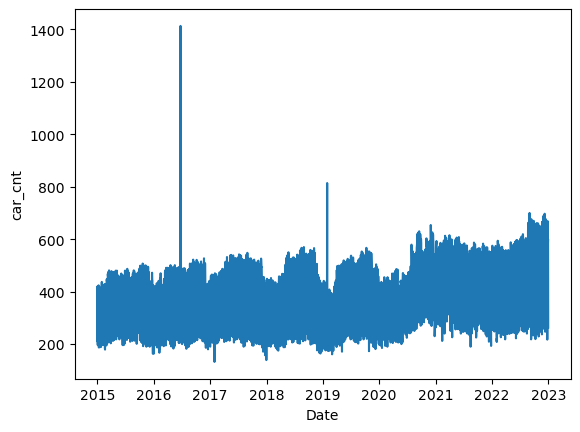

In [102]:
sns.lineplot(x='Date', y='car_cnt', data=df_taxi);

<Axes: >

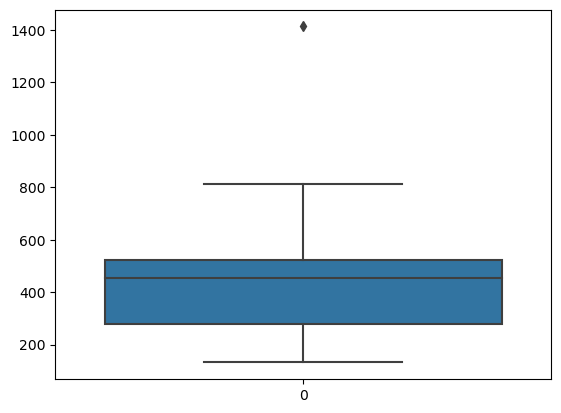

In [103]:
sns.boxplot(df_taxi['car_cnt'])

* 접수건, 탑승건

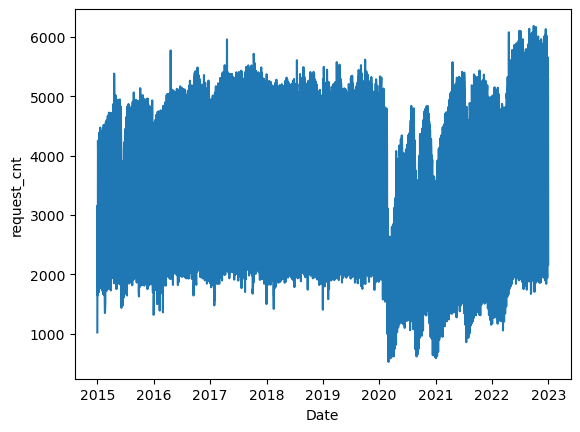

In [104]:
sns.lineplot(x='Date', y='request_cnt', data=df_taxi);

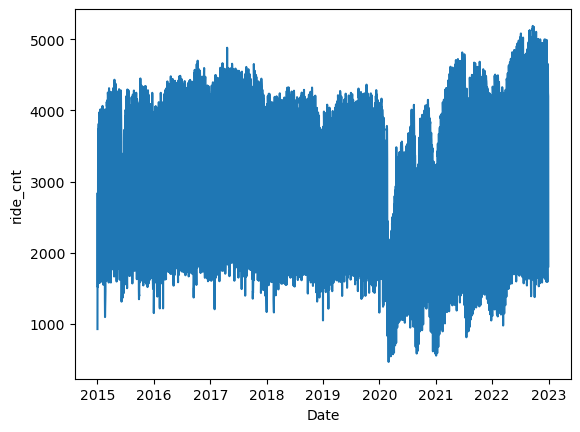

In [105]:
sns.lineplot(x='Date', y='ride_cnt', data=df_taxi);

* 대기시간

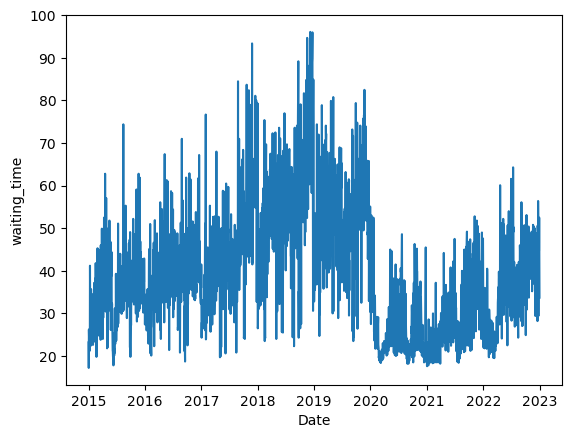

In [106]:
sns.lineplot(x='Date', y='waiting_time', data=df_taxi);

* 운임

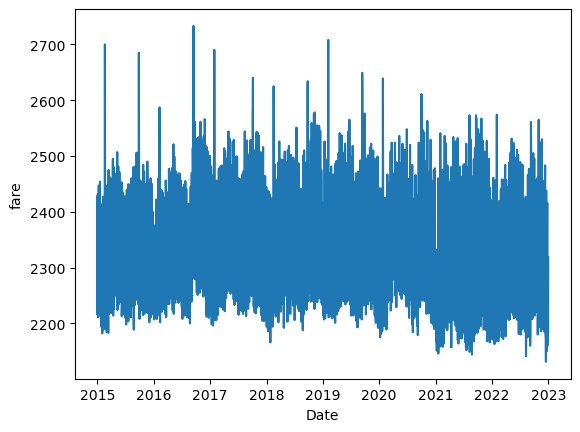

In [107]:
sns.lineplot(x='Date', y='fare', data=df_taxi);

* 이동거리

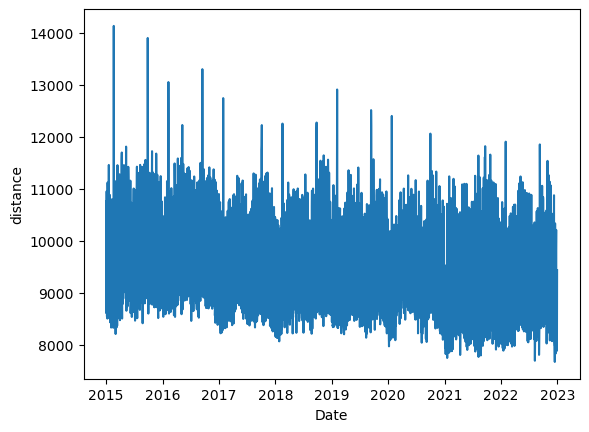

In [108]:
sns.lineplot(x='Date', y='distance', data=df_taxi);

### (3) 요일별 (boxplot활용)

* 차량 운행수

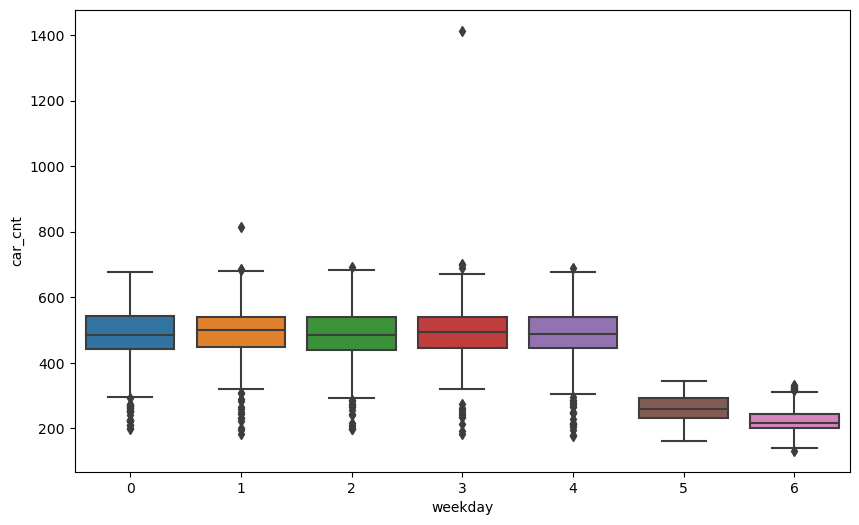

In [109]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y='car_cnt', data=df_taxi)
plt.show()

* 접수건, 탑승건

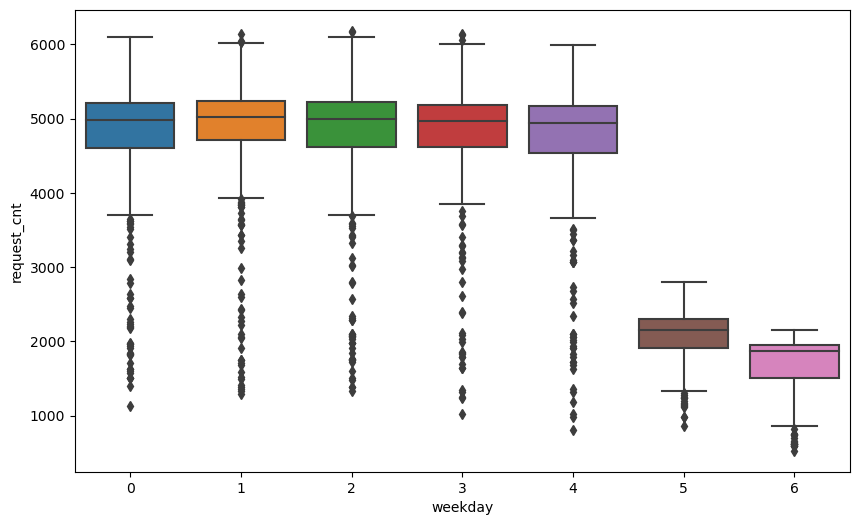

In [110]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y='request_cnt', data=df_taxi)
plt.show()

* 대기시간

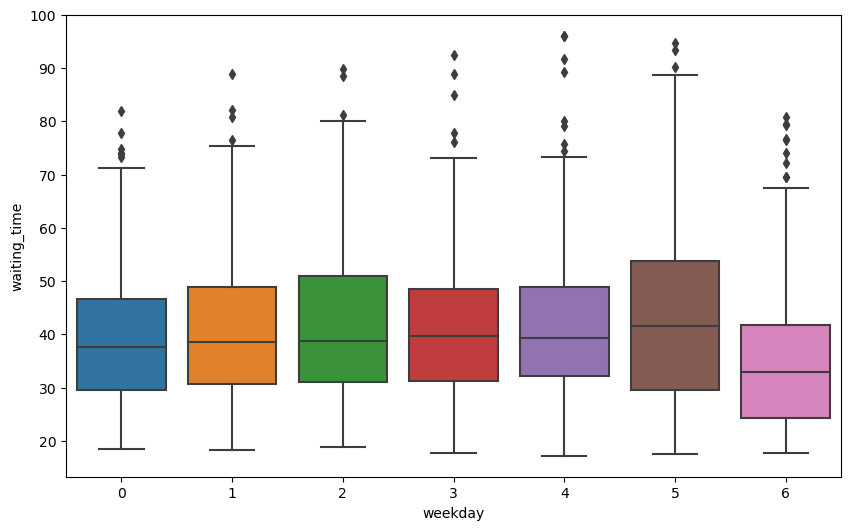

In [111]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y='waiting_time', data=df_taxi)
plt.show()

* 운임

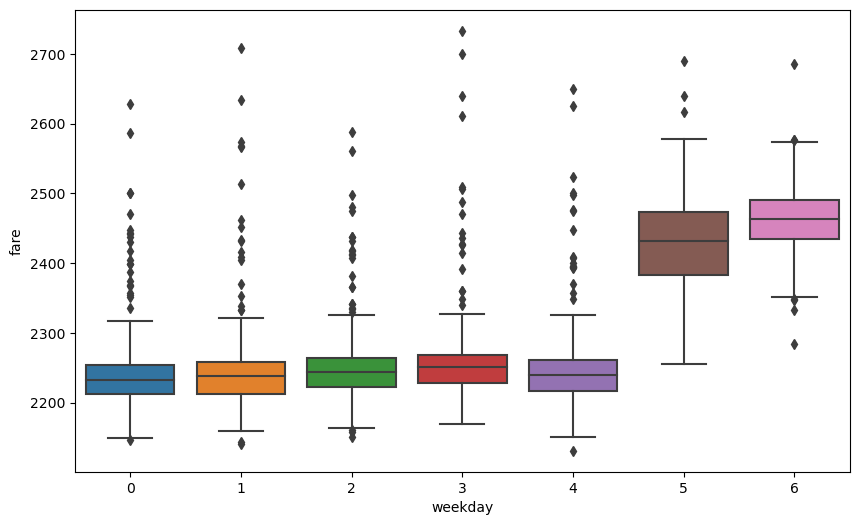

In [112]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y='fare', data=df_taxi)
plt.show()

* 이동거리

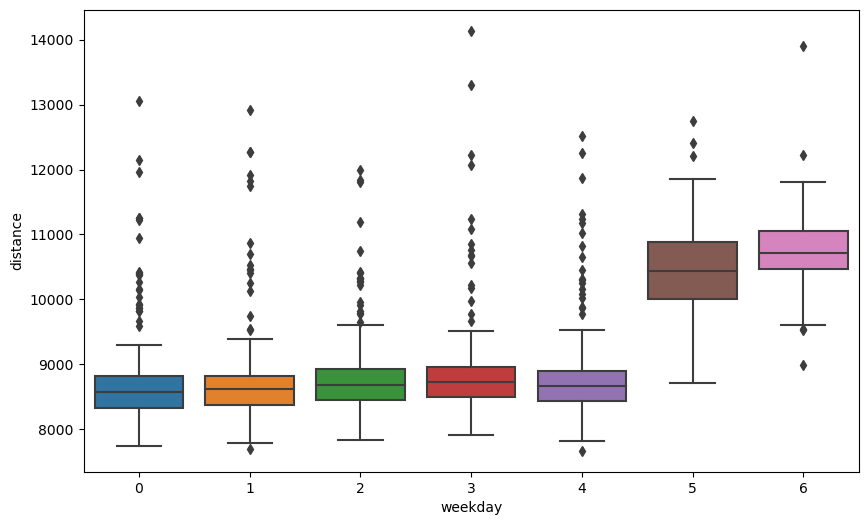

In [113]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y='distance', data=df_taxi)
plt.show()

### (4) 월별 (boxplot활용)

* 차량 운행수

In [114]:
def make_boxplot(col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='month', y=col, data=df_taxi)
    plt.title(f'{col}')
    plt.show()


In [115]:
df_taxi.columns.difference(['Date','year','week', 'weekday','month'])

Index(['car_cnt', 'distance', 'fare', 'request_cnt', 'ride_cnt',
       'waiting_time'],
      dtype='object')

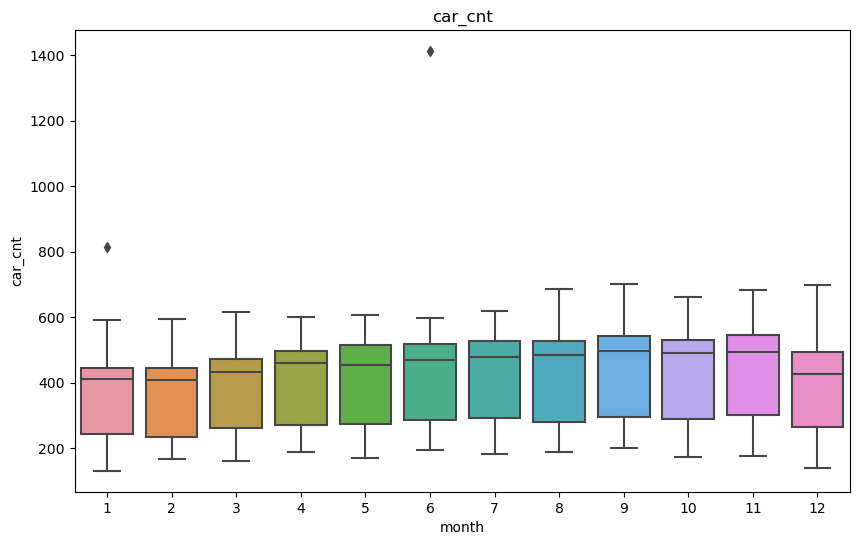

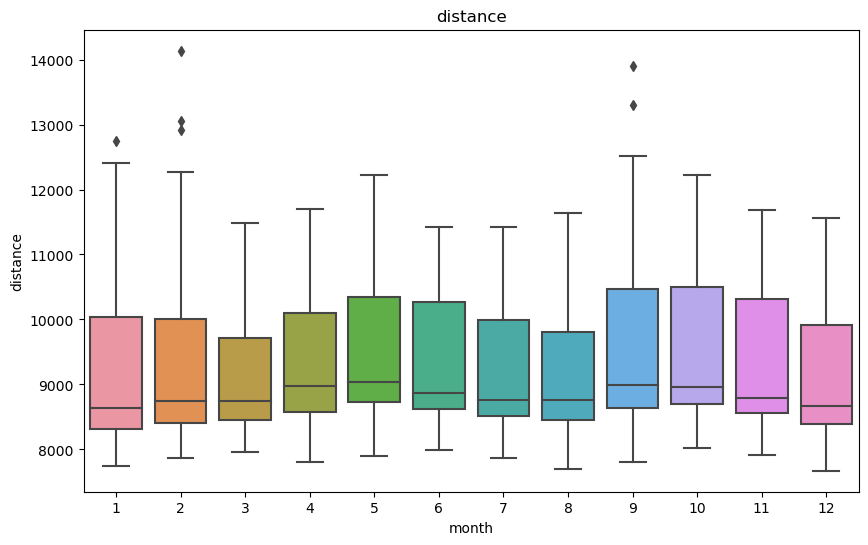

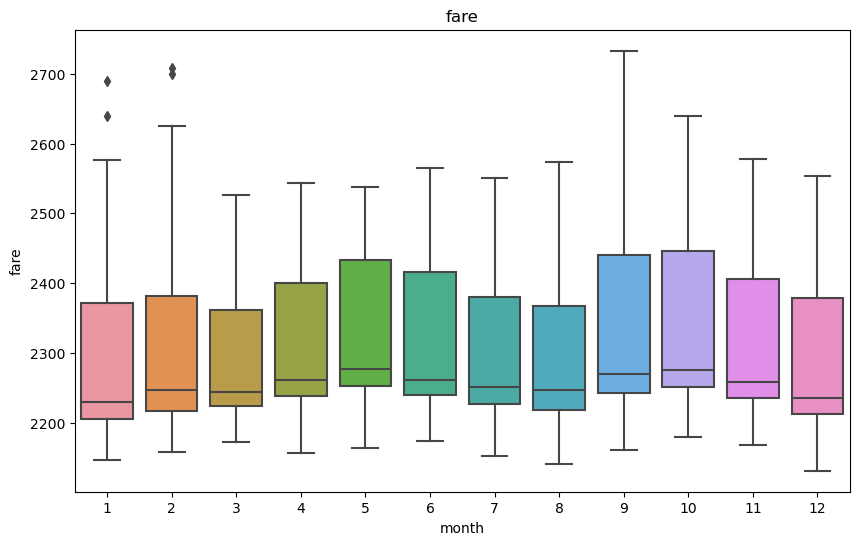

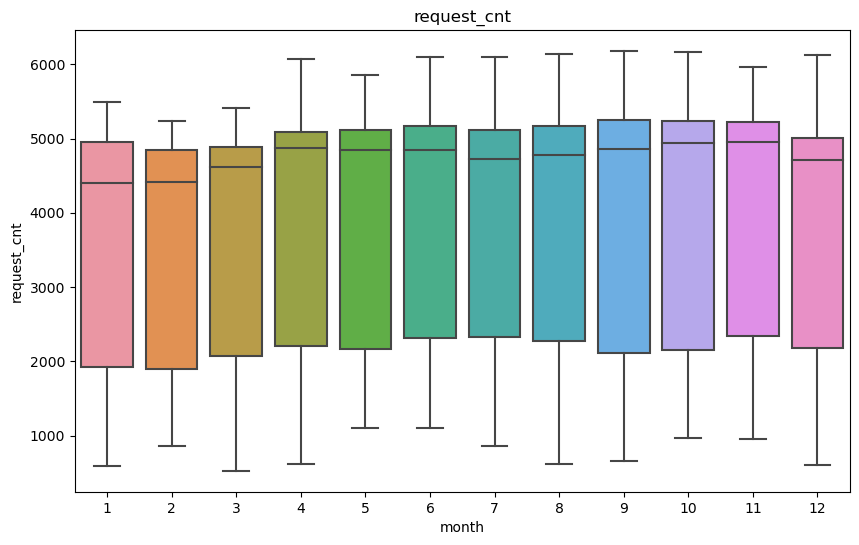

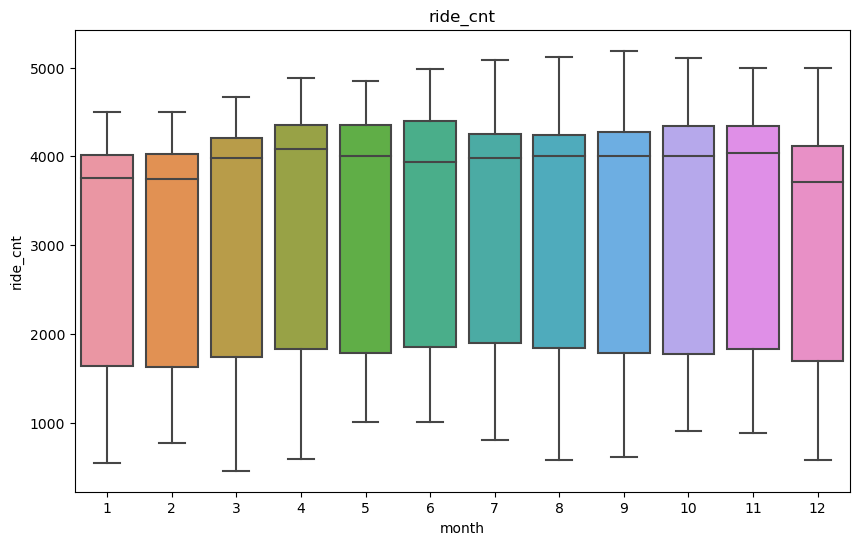

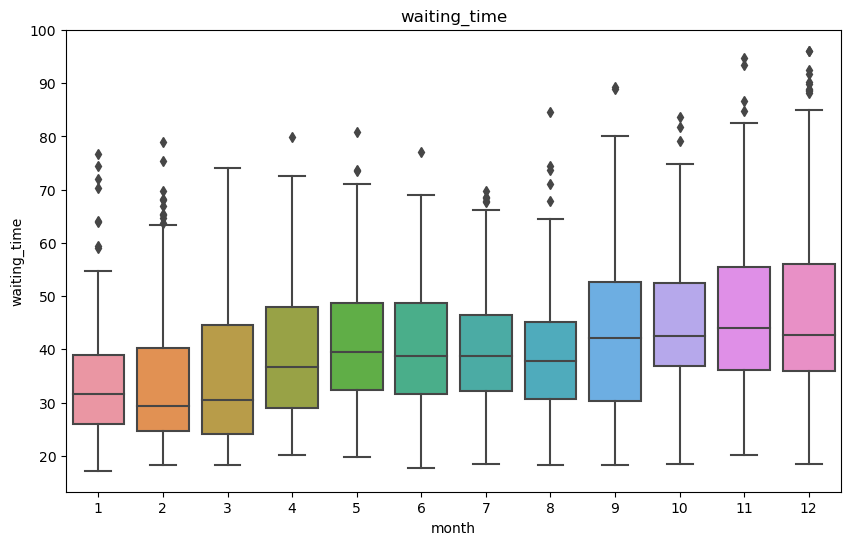

In [116]:
for col in df_taxi.columns.difference(['Date','year','week', 'weekday','month']):
    make_boxplot(col)
    print('='*100)
    print()

### (5) 연도별 (boxplot 활용)

In [117]:
def make_boxplot_year(col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='year', y=col, data=df_taxi)
    plt.title(f'{col}')
    plt.show()


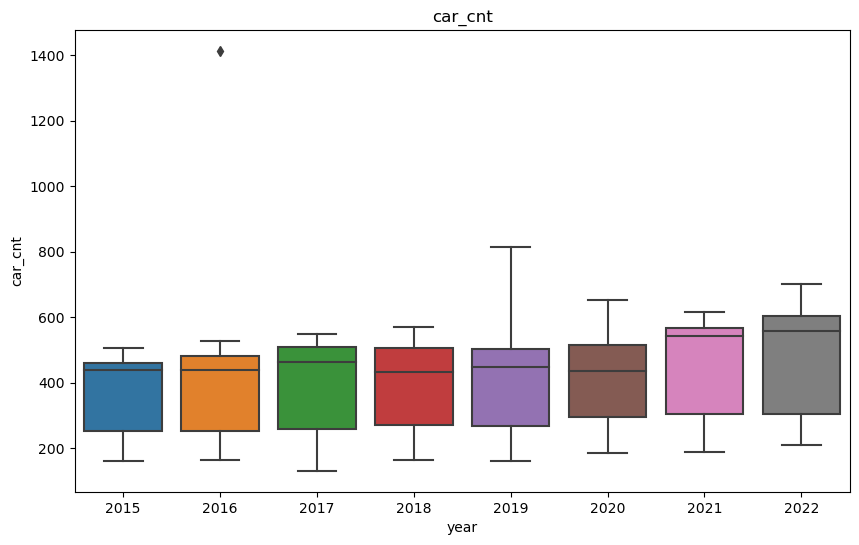

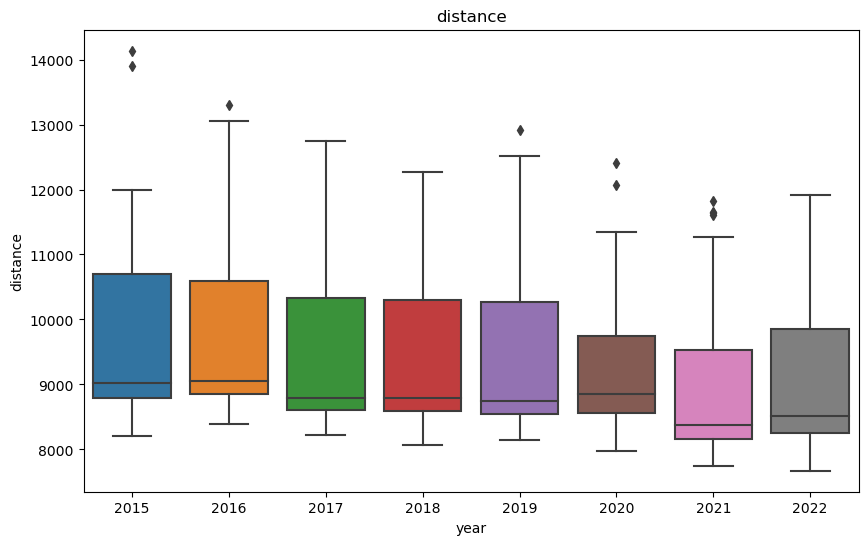

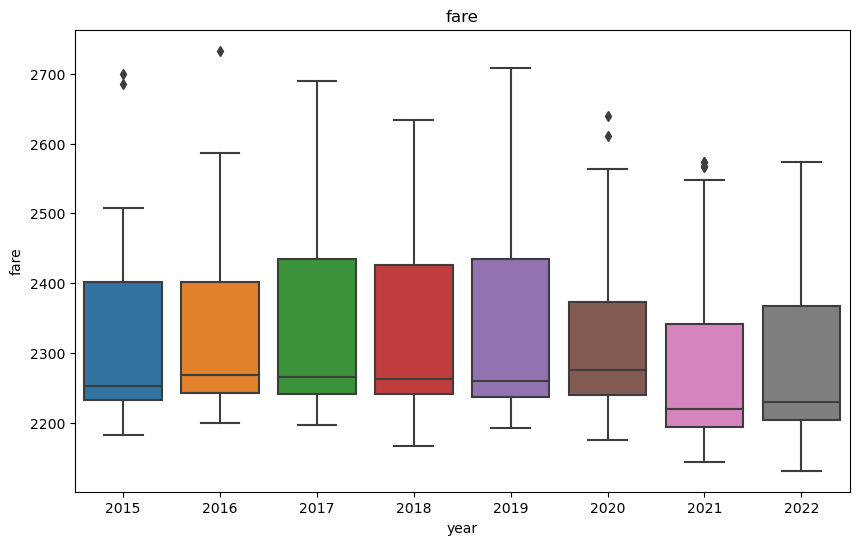

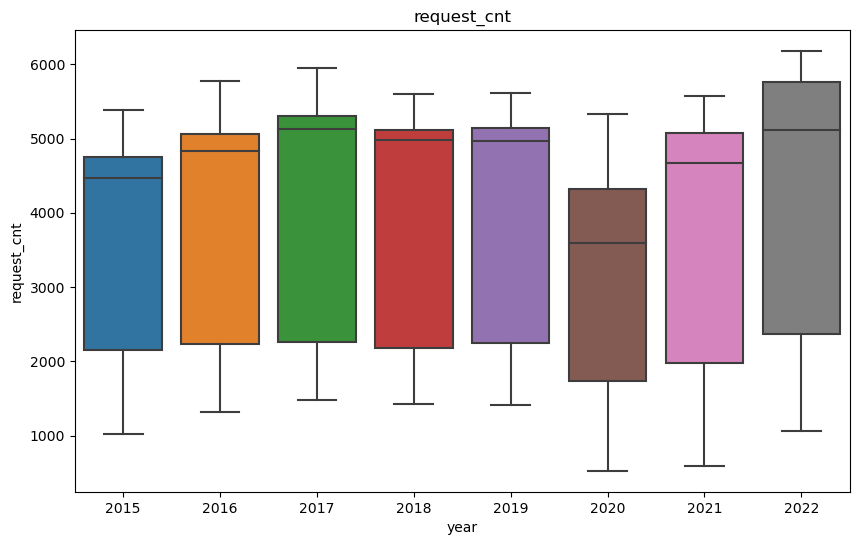

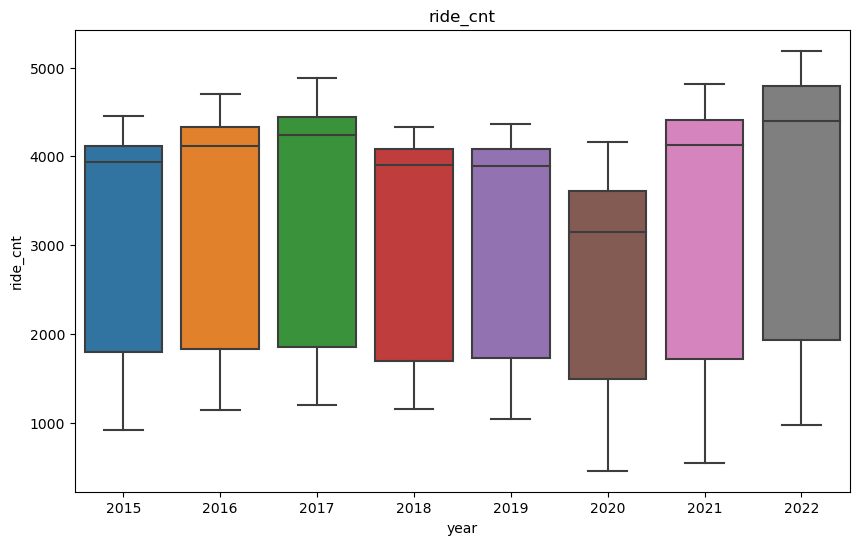

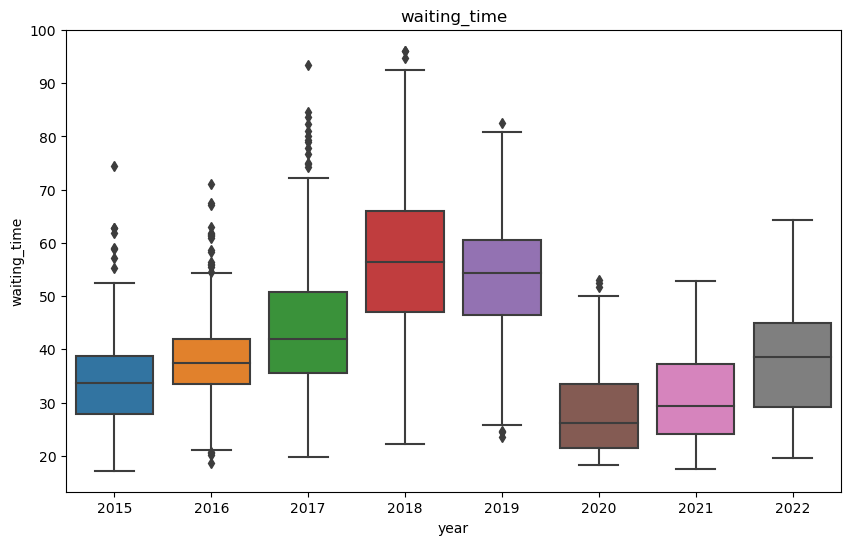

In [118]:
for col in df_taxi.columns.difference(['Date','year','week', 'weekday','month']):
    make_boxplot_year(col)
    print('='*100)
    print()

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [119]:
df_taxi['target'] = df_taxi['waiting_time'].shift(-1)
df_taxi.dropna(inplace=True)
df_taxi.tail()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday,month,week,year,target
2916,2022-12-26,603,5555,4605,39.2,2163,7889,0,12,52,2022,44.4
2917,2022-12-27,669,5635,4654,44.4,2198,8178,1,12,52,2022,44.8
2918,2022-12-28,607,5654,4648,44.8,2161,7882,2,12,52,2022,52.5
2919,2022-12-29,581,5250,4247,52.5,2229,8433,3,12,52,2022,38.3
2920,2022-12-30,600,5293,4200,38.3,2183,8155,4,12,52,2022,33.7


### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

In [120]:
df_weather_tmp = df_weather.copy()
df_weather_tmp['Date'] = df_weather['Date'].shift(-1)
df_weather_tmp.dropna(inplace=True)
df_weather_tmp.tail()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
4012,2022-12-27,1.5,-7.9,0.0,85.0,46.0,8.27
4013,2022-12-28,3.0,-7.3,0.0,86.0,51.0,10.25
4014,2022-12-29,-0.3,-5.4,0.1,92.0,40.0,10.86
4015,2022-12-30,1.7,-7.8,0.0,71.0,34.0,10.88
4016,2022-12-31,2.1,-4.0,0.0,87.0,38.0,10.84


In [121]:
df_merge = pd.merge(df_taxi, df_weather_tmp, how='inner', on='Date')
df_merge

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday,month,week,year,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,1,2015,17.2,-1.6,-1.6,0.0,64.0,64.0,0.00
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,1,2015,26.2,-4.3,-9.8,0.0,52.0,33.0,9.79
2,2015-01-03,209,1648,1514,26.2,2377,10198,5,1,1,2015,24.5,-2.0,-8.9,0.0,63.0,28.0,9.07
3,2015-01-04,196,1646,1526,24.5,2431,10955,6,1,1,2015,26.2,2.4,-9.2,0.0,73.0,37.0,8.66
4,2015-01-05,421,4250,3730,26.2,2214,8663,0,1,2,2015,23.6,8.2,0.2,0.0,89.0,58.0,5.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2022-12-26,603,5555,4605,39.2,2163,7889,0,12,52,2022,44.4,-0.2,-9.5,0.0,81.0,47.0,10.89
2917,2022-12-27,669,5635,4654,44.4,2198,8178,1,12,52,2022,44.8,1.5,-7.9,0.0,85.0,46.0,8.27
2918,2022-12-28,607,5654,4648,44.8,2161,7882,2,12,52,2022,52.5,3.0,-7.3,0.0,86.0,51.0,10.25
2919,2022-12-29,581,5250,4247,52.5,2229,8433,3,12,52,2022,38.3,-0.3,-5.4,0.1,92.0,40.0,10.86


### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [123]:
df_merge['season'] = df_merge['month']
df_merge.loc[df_merge['season'].isin([3, 4, 5]), 'season'] = 'Spring'
df_merge.loc[df_merge['season'].isin([6, 7, 8]), 'season'] = 'Summer'
df_merge.loc[df_merge['season'].isin([9, 10, 11]), 'season'] = 'Fall'
df_merge.loc[df_merge['season'].isin([12, 1, 2]), 'season'] = 'Winter'

In [124]:
df_merge.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday,month,week,year,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,1,2015,17.2,-1.6,-1.6,0.0,64.0,64.0,0.00,Winter
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,1,2015,26.2,-4.3,-9.8,0.0,52.0,33.0,9.79,Winter
2,2015-01-03,209,1648,1514,26.2,2377,10198,5,1,1,2015,24.5,-2.0,-8.9,0.0,63.0,28.0,9.07,Winter
3,2015-01-04,196,1646,1526,24.5,2431,10955,6,1,1,2015,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,Winter
4,2015-01-05,421,4250,3730,26.2,2214,8663,0,1,2,2015,23.6,8.2,0.2,0.0,89.0,58.0,5.32,Winter


In [125]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2921 non-null   datetime64[ns]
 1   car_cnt          2921 non-null   int64         
 2   request_cnt      2921 non-null   int64         
 3   ride_cnt         2921 non-null   int64         
 4   waiting_time     2921 non-null   float64       
 5   fare             2921 non-null   int64         
 6   distance         2921 non-null   int64         
 7   weekday          2921 non-null   int64         
 8   month            2921 non-null   int64         
 9   week             2921 non-null   UInt32        
 10  year             2921 non-null   int64         
 11  target           2921 non-null   float64       
 12  temp_max         2921 non-null   float64       
 13  temp_min         2921 non-null   float64       
 14  rain(mm)         2921 non-null   float64

#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [126]:
# !pip install workalendar

^C


* 간단 사용법

In [127]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [128]:
holidays_df = pd.DataFrame(cal.holidays(2015))
for i in range(2016, 2023):
    temp = pd.DataFrame(cal.holidays(i))
    holidays_df = pd.concat([holidays_df, temp], axis=0, join='outer')

holidays_df.columns = ['Date', 'holiday']
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'], format='%Y-%m-%d')  # 날짜 타입으로 변환
holidays_df

,Date,holiday
0,2015-01-01,New year
1,2015-02-18,Korean New Year's Day
2,2015-02-19,Korean New Year's Day
3,2015-02-20,Korean New Year's Day
4,2015-03-01,Independence Day
...,...,...
10,2022-09-10,Midautumn Festival
11,2022-09-11,Midautumn Festival
12,2022-10-03,National Foundation Day
13,2022-10-09,Hangul Day


* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [129]:
print(holidays_df[holidays_df['Date'].duplicated(keep=False)])

         Date                  holiday
9  2017-10-03       Midautumn Festival
10 2017-10-03  National Foundation Day


In [130]:
holidays_df.drop_duplicates(subset=['Date'], inplace=True)
df_w_m = pd.merge(df_merge, holidays_df, how='left', on='Date')
df_w_m['holiday'].fillna(0, inplace=True)
df_w_m.loc[df_w_m['holiday'] != 0, 'holiday'] = 1

In [131]:
df_w_m

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday,month,week,year,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,holiday
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,1,2015,17.2,-1.6,-1.6,0.0,64.0,64.0,0.00,Winter,1
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,1,2015,26.2,-4.3,-9.8,0.0,52.0,33.0,9.79,Winter,0
2,2015-01-03,209,1648,1514,26.2,2377,10198,5,1,1,2015,24.5,-2.0,-8.9,0.0,63.0,28.0,9.07,Winter,0
3,2015-01-04,196,1646,1526,24.5,2431,10955,6,1,1,2015,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,Winter,0
4,2015-01-05,421,4250,3730,26.2,2214,8663,0,1,2,2015,23.6,8.2,0.2,0.0,89.0,58.0,5.32,Winter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2022-12-26,603,5555,4605,39.2,2163,7889,0,12,52,2022,44.4,-0.2,-9.5,0.0,81.0,47.0,10.89,Winter,0
2917,2022-12-27,669,5635,4654,44.4,2198,8178,1,12,52,2022,44.8,1.5,-7.9,0.0,85.0,46.0,8.27,Winter,0
2918,2022-12-28,607,5654,4648,44.8,2161,7882,2,12,52,2022,52.5,3.0,-7.3,0.0,86.0,51.0,10.25,Winter,0
2919,2022-12-29,581,5250,4247,52.5,2229,8433,3,12,52,2022,38.3,-0.3,-5.4,0.1,92.0,40.0,10.86,Winter,0


#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [133]:
df_w_m['ave_waiting_time'] = round(df_w_m['waiting_time'].rolling(7, min_periods=1).mean(),2)
df_w_m.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday,month,week,...,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,holiday,ave_waiting_time
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,1,...,17.2,-1.6,-1.6,0.0,64.0,64.0,0.00,Winter,1,23.20
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,1,...,26.2,-4.3,-9.8,0.0,52.0,33.0,9.79,Winter,0,20.20
2,2015-01-03,209,1648,1514,26.2,2377,10198,5,1,1,...,24.5,-2.0,-8.9,0.0,63.0,28.0,9.07,Winter,0,22.20
3,2015-01-04,196,1646,1526,24.5,2431,10955,6,1,1,...,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,Winter,0,22.78
4,2015-01-05,421,4250,3730,26.2,2214,8663,0,1,2,...,23.6,8.2,0.2,0.0,89.0,58.0,5.32,Winter,0,23.46


#### 4) 탑승률

In [134]:
df_w_m['ride_rate'] = df_w_m['ride_cnt']/df_w_m['request_cnt'] * 100
df_w_m.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday,month,week,...,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,holiday,ave_waiting_time,ride_rate
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,1,...,-1.6,-1.6,0.0,64.0,64.0,0.00,Winter,1,23.20,90.322581
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,1,...,-4.3,-9.8,0.0,52.0,33.0,9.79,Winter,0,20.20,89.898670
2,2015-01-03,209,1648,1514,26.2,2377,10198,5,1,1,...,-2.0,-8.9,0.0,63.0,28.0,9.07,Winter,0,22.20,91.868932
3,2015-01-04,196,1646,1526,24.5,2431,10955,6,1,1,...,2.4,-9.2,0.0,73.0,37.0,8.66,Winter,0,22.78,92.709599
4,2015-01-05,421,4250,3730,26.2,2214,8663,0,1,2,...,8.2,0.2,0.0,89.0,58.0,5.32,Winter,0,23.46,87.764706


## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

In [135]:
import joblib

joblib.dump(df_w_m, 'data1.pkl')

['data1.pkl']